# Replication of what was done for the patterns to the HEP folder

With only slight modifications

In [ ]:
image_reshape_size = 96 # multiple of 32, to fit better with VGG16
# values from image_study notebook
minimum_number_pixels = 1000 
maximum_percentage_black_pixels = 0.5

# Imports

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import multiprocessing as mp
from sklearn.preprocessing import OneHotEncoder
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as spc

Mounting the drive

In [ ]:

# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image viewing utils


In [ ]:
def cells_plot(X, image_shape, collumn_size):
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  # for every cell in image
  for i, x in enumerate(X):
    if count == 0:
      row = np.c_[x, np.zeros((image_shape,2))]
    else:
      row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
    count += 1
    if count == collumn_size:
      n += collumn_size
      out = np.r_[out, np.zeros((2,limit))]
      out = np.r_[out, row]
      row = np.array([])
      count = 0
      if n>99:
        break
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n


#%% SECTION de definition et d'imports a lancer au debut
# Si vous êtes dans colab mettre colaboratory ET notebook a True
# si vous êtes en local dans un notebook mettez colbaoratory a False
#      et installez bokeh vous-même
# Si vous utilisez le script sur une machine local non pas dans un notebook 
# mettez les deux à False 
notebook=True
colaboratory=True
if notebook:
    from IPython.display import Audio
    if colaboratory:
        !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    from bokeh.colors import Color as bcolor
    from bokeh.colors.rgb import RGB


import numpy as np

import matplotlib.pyplot as plt
import scipy 
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os

def RGBtoYCrCb(im,ty='8bit'): 
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs 
                    # possibles. 
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out
    
import skimage.transform
if notebook:
  liste_couleurs_grises=[]
  for k in range(256):
    liste_couleurs_grises.append(RGB(k,k,k))
  def affiche_pour_colab(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''): #special colab, ne pas regarder
    def normalise_image_pour_bokeh(X,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
      Y=(X.copy())
      if len(Y.shape)==2: 
        Y=np.zeros((*Y.shape,3))
        for k in range(3):
          Y[:,:,k]=X.copy()
   
      if normalise:
        Y-=Y.min()
        Y/=Y.max()
        Y*=255
      else:
        Y-=MINI
        Y/=(MAXI-MINI)
        Y*=255

      Y=Y.astype(np.uint8)
      sortie=np.empty(Y.shape[:2],dtype=np.uint32)
      view=sortie.view(dtype=np.uint8).reshape((Y.shape[:2]+(4,)))
      for k in range(3):
        view[:,:,k]=Y[:,:,k]
      view[:,:,3]=255
      return sortie
    img=normalise_image_pour_bokeh(np.flipud(im),normalise=normalise,MINI=MINI,MAXI=MAXI)# np.flipud(np.fliplr(im)))
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    p.x_range.range_padding = p.y_range.range_padding = 0

    # must give a vector of images
    p.image_rgba(image=[img],x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    showbokeh(p)

  def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
      affiche_pour_colab(im,normalise=normalise,MINI=MINI, MAXI=MAXI,titre=titre) 
         # sous google colab beaucoup d''options disparaissent

else:
    def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
        """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image 
        resultat
        """
        imt=np.float32(im.copy())
        if platform.system()=='Darwin': #on est sous mac
            prephrase='open -a GIMP-2.10.app ' #certainement à adapter
            endphrase=' ' 
        else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment 
                                   #faire. Si vous savez dites-moi.)
            prephrase='gimp '
            endphrase= ' &'
    
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
    
        if titre!='':
            titre='_'+titre+'_'
        titre=titre.replace(' ','')
        nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
        commande=prephrase +nomfichier+endphrase
        os.system(commande)
        if printname:
            print(nomfichier)


if notebook:
    def plot(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif (len(argv)==1):
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: n'arriverait \
                pas hors de google colaboratory")
    
        p=figure()
        p.line(x,y)
        showbokeh(p)
    def stem(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif len(argv)==1:
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: \
                            n'arriverait pas hors de google colaboratory")

        p = figure()#title="simple line example", x_axis_label='x',
                    #y_axis_label='y')

        # add a line renderer with legend and line thickness
        p.segment(x,0,x, y, legend_label="Temp.", line_width=2)

        showbokeh(p)
    def show():
        return
else:
    plot=plt.plot
    stem=plt.stem
    show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5

# Importing images

In [ ]:
def get_patterns(pattern_folder, cell_number_limit, green=False):
  print('Importing...')
  n_classes = len(glob.glob(pattern_folder + '/*'))
  y_pattern_dict = n_classes*[None]

  X = [] #dataset
  y = []
  i = 0
  dif = 0
  hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
  hist_percentage_cyto = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern

  for pattern_path in sorted(glob.glob(pattern_folder + '/*')): #iterating in every pattern
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
    print(f'Importing patterns: {pattern_name} - {i}/{n_classes}')
    number_of_images = 0
    while number_of_images<cell_number_limit:
      for idx, np_cells in enumerate(glob.glob(pattern_path + '/*')):#iterating for every numpy array
        if number_of_images>=cell_number_limit:
          break
        
        if (green == True and np_cells[-5]=='G') or (green == False and np_cells[-5]!='G'):
          a = np.load(np_cells, allow_pickle=True) #gets array from drive
          print(f'{np_cells[len(pattern_path)+1:]} - {len(a)}') 
          number_of_images += len(a)
          # One hot encoder
          auxy = np.zeros(n_classes)
          auxy[i] = 1
          for j in range(len(a)):
            y.append(auxy)
          
          #histogram construction
          for img in a:
            X.append(img[:,:,0])
            size = img.shape[0]*img.shape[1]
            hist_pixel_count[i].append(size)
            hist_percentage_cyto[i].append(100*np.count_nonzero(img[:,:,2]==0)/size)
          # augmentation for missing images
          # check for errors
          if len(X) != len(y):
            if len(X) - len(y) != dif:
              err_npy = np_cells
              dif = len(X) - len(y)
            print(f'problem: {err_npy} / {len(X)} - {len(y)}')
            return a, y, X, 0, 0, 0
    i += 1
  y = np.array(y)
  return X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto

def get_patterns_by_image(pattern_folder, cell_number_limit, image_path, green=True):
  print('Importing...')
  n_classes = len(glob.glob(pattern_folder + '/*'))
  y_pattern_dict = n_classes*[None]
  
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  #dataset
  image_x = []
  image_y = []
  hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
  hist_percentage_cyto = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern
  i = 0
  dif = 0
  cells_paths = sorted(glob.glob(pattern_folder + '/*'))
  images = sorted(glob.glob(image_path + '/*'))
  for number_of_images, pattern_path in enumerate(cells_paths): #iterating in every pattern
    X = []
    y = []
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
    for aux in sorted(glob.glob(images[number_of_images] + '/*')):
      if aux[-3:]=='jpg':
        img = np.asarray(cv2.imread(aux))
        img[:,:,1] = clahe.apply(img[:,:,1])
        plt.figure(figsize=(20,10))
        plt.imshow(img)
        plt.title(f'Pattern {pattern_name}')
        plt.show()
        break
    for count_images,np_cells in enumerate(glob.glob(pattern_path + '/*')):#iterating for every numpy array
      if (green == True and np_cells[-5]=='G') or (green == False and np_cells[-5]!='G'):
        a = np.load(np_cells, allow_pickle=True) #gets array from drive
        print(f'{np_cells[len(pattern_path)+1:]} - {len(a)}') 
        number_of_images += len(a)
        # One hot encoder
        auxy = np.zeros(n_classes)
        auxy[i] = 1
        for j in range(len(a)):
          y.append(auxy)
        
        #histogram construction
        for img in a:
          X.append(img[:,:,0])
          size = img.shape[0]*img.shape[1]
          hist_pixel_count[i].append(size)
          hist_percentage_cyto[i].append(100*np.count_nonzero(img[:,:,2]==0)/size)
        # augmentation for missing images
        # check for errors
        if len(X) != len(y):
          if len(X) - len(y) != dif:
            err_npy = np_cells
            dif = len(X) - len(y)
          print(f'problem: {err_npy} / {len(X)} - {len(y)}')
          return a, y, X, 0, 0, 0
      
    i += 1
    image_x.append(X) 
    image_y.append(np.array(y))
  return image_x, image_y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto


# Preparing the dataset

In [ ]:
def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black square around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    #print(i)
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def standardize_classes(X, y):
  Xcopy = X.copy()
  for i in range(len(y[0])): #iterating between 14 classes
    arr = np.where(y[:, i]==1)[0]
    max_dimension = 0
    for cell in X[arr]: #find the largest dimension in a given class
      max_dimension = max(cell.shape[0], max_dimension)
    for j in arr:
      aux = np.zeros((max_dimension, max_dimension))
      margin = int((max_dimension - X[j].shape[0])/2)
      aux[margin: margin + X[j].shape[0], margin: margin + X[j].shape[0]] = X[j]
      Xcopy[j] = aux
  return Xcopy

def resize_square(X, cnn_input_size, upscaling=False, full_size=True):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square if upscaling is false
      #If upscaling is true, then it upscales
    # for bigger cells: downscaling
  if full_size:
    Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
    for i in range(len(X)):
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
      Xcopy[i] = np.asarray(aux, 'float32')
    return Xcopy
  if upscaling==True:
    X = standardize_classes(X, y)
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size and upscaling==False:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size or upscaling==True:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float16')
  return Xcopy

def grayscale_2_3channel(X):
  #copies grayscale into other channels for VGG
  return np.repeat(np.expand_dims(X, 3), 3, axis=3)
  
def filter_db(X, y, pixel_count, percentage):
  # returns X and y inside parameters of
  # pixel_count and percentage of empty space
  Xl = []
  yl = []
  for i in range(len(X)):
    iclass = np.argmax(y[i])
    size = X[i].shape[0]*X[i].shape[1]
    percent = (100*np.count_nonzero(X[i]==0))/size
    if size < pixel_count[iclass][0] and size > pixel_count[iclass][1]:
      if percent < percentage[iclass][0] and percent > percentage[iclass][1]:
        Xl.append(X[i])
        yl.append(y[i])
  return Xl,np.asarray(yl)

def data_augmentation(X, y):
  # data augmentation using fliping and rotation
  x_out = np.copy(X)
  y_out = np.copy(y)
  flips = np.asarray([np.flipud(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.fliplr(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.flip(img, (0, 1)) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  return x_out, y_out


def data_preparation (X, y, split_test, hist_pixel_count, hist_percentage, image_reshape_size, y_pattern_dict):
  
  print("Filtering")
  pixel_parameters = get_parameters(hist_pixel_count, len(y_pattern_dict), y_pattern_dict)
  percentage_parameters = get_parameters(hist_percentage, len(y_pattern_dict), y_pattern_dict, True)
  X_filtered, y_filtered = filter_db(X, y, pixel_parameters, percentage_parameters)
  if split_test:
    print(f'the total number of images is: {len(y)}')
    print(f'the number of images with these restrictions is: {len(y_filtered)}')
  print('Normalizing images')
  imgs_normalized = normalize(X_filtered)
  print("Making cells square")
  square = transform_square(imgs_normalized)
  print("Resizing to the correct size for classification")
  res_square = resize_square(square, image_reshape_size)
  #print(np.max(res_square))
  cells = grayscale_2_3channel(res_square)
  print("Train test splitting")
  if split_test:
    Xtrain, Xtest, ytrain, ytest = train_test_split(cells, y_filtered, test_size=0.25, random_state=42)
    print('Data augmentation')
    Xtrain, ytrain = data_augmentation(Xtrain, ytrain)
    return Xtrain, ytrain, Xtest, ytest
  return cells, y_filtered

def normalize(X):
    for idx, img in enumerate(X):
        ar = np.array(img).astype(np.float32)
        mn = np.min(ar)
        mx = np.max(ar)
        X[idx] = (ar - mn) * (1.0 / (mx - mn))
    return X


def get_parameters(hist, n_classes, y_pattern_dict, percent=False):
  # gets parameters for filtering
  critical_out = []
  for i in range(n_classes):
    critical1 = np.quantile(hist[i], 0.9)
    if percent:
      critical2 = np.quantile(hist[i], 0.1)
    else:
      critical2 = np.quantile(hist[i], 0.1)
    critical_out.append((int(critical1), int(critical2)))
  return critical_out

# Main

Studying the number of images

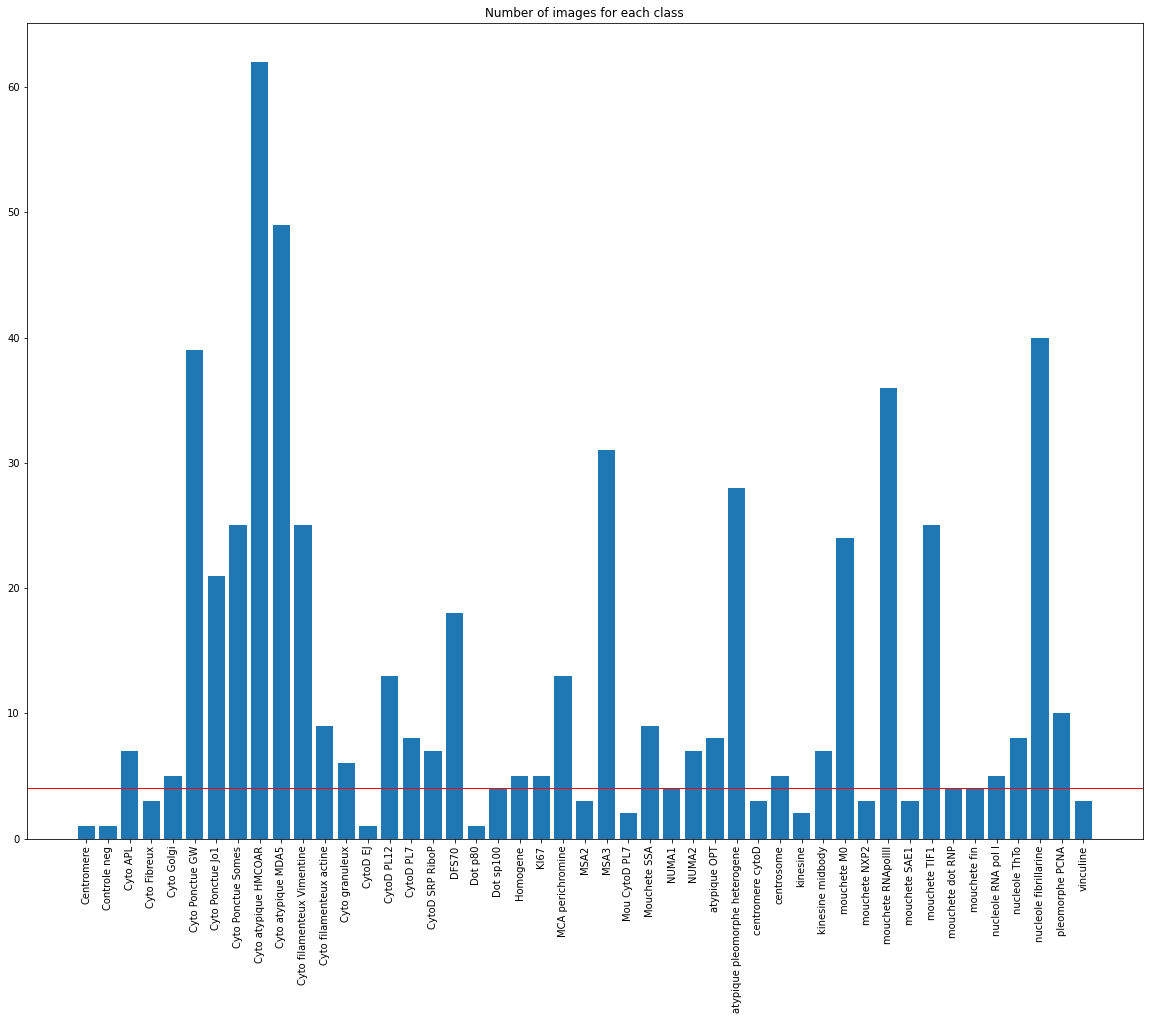

Number of classes with less than 4 images: 12/47


In [ ]:
pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells'

sizes_of_classes = [len(glob.glob(pattern_path + '/*'))//2 for pattern_path in glob.glob(pattern_folder + '/*')]

n_classes = len(glob.glob(pattern_folder + '/*'))
y_pattern_dict = n_classes*[None]
for i, pattern_path in enumerate(sorted(glob.glob(pattern_folder + '/*'))): #iterating in every pattern
    pattern_name =  pattern_path[len(pattern_folder)+1:] #Name of pattern
    y_pattern_dict[i] = pattern_name
y_pattern_dict[i] = pattern_name
plt.figure(figsize=(20,15))
plt.title("Number of images for each class")
plt.xticks(rotation='vertical')
plt.axhline(y=4,linewidth=1, color='red')
plt.bar(y_pattern_dict,sizes_of_classes)
plt.show()

print(f"Number of classes with less than 4 images: {(np.asarray(sizes_of_classes, dtype=int)<4).sum()}/{n_classes}")

In [ ]:
# number of images
pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells'
X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto = get_patterns(pattern_folder, 200, green=True)

Importing...
Importing patterns: Centromere - 0/47
Centromere_1G.npy - 76
Centromere_1G.npy - 76
Centromere_1G.npy - 76
Importing patterns: Controle neg - 1/47
Controle neg_1G.npy - 134
Controle neg_1G.npy - 134
Importing patterns: Cyto APL - 2/47
Cyto APL_1G.npy - 49
Cyto APL_2G.npy - 29
Cyto APL_3G.npy - 39
Cyto APL_4G.npy - 24
Cyto APL_5G.npy - 67
Importing patterns: Cyto Fibreux - 3/47
Cyto Fibreux_1G.npy - 34
Cyto Fibreux_2G.npy - 22
Cyto Fibreux_3G.npy - 50
Cyto Fibreux_1G.npy - 34
Cyto Fibreux_2G.npy - 22
Cyto Fibreux_3G.npy - 50
Importing patterns: Cyto Golgi - 4/47
Cyto Golgi_1G.npy - 33
Cyto Golgi_2G.npy - 45
Cyto Golgi_3G.npy - 47
Cyto Golgi_4G.npy - 61
Cyto Golgi_5G.npy - 44
Importing patterns: Cyto Ponctue GW - 5/47
Cyto Ponctue GW_1G.npy - 55
Cyto Ponctue GW_2G.npy - 49
Cyto Ponctue GW_3G.npy - 45
Cyto Ponctue GW_4G.npy - 52
Importing patterns: Cyto Ponctue Jo1 - 6/47
Cyto Ponctue Jo1_1G.npy - 54
Cyto Ponctue Jo1_2G.npy - 56
Cyto Ponctue Jo1_3G.npy - 0
Cyto Ponctue Jo1_4G

Preparing the dataset

In [ ]:
x_train, y_train, x_test, y_test = data_preparation(X, y, True, hist_pixel_count, hist_percentage_cyto, image_reshape_size, y_pattern_dict)

Filtering
the total number of images is: 10531
the number of images with these restrictions is: 7155
Normalizing images
Making cells square
Resizing to the correct size for classification
Train test splitting
Data augmentation


Load classification model

In [ ]:
# load model without classifier layers
K.clear_session()

def get_classes_model():
  model = VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet')
  for layer in model.layers:
      layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  class2 = Dense(1024, activation='relu')(class1)
  drop = Dropout(0.5)(class2)
  output = Dense(n_classes, activation='softmax')(drop)
  # define new model
  model = Model(inputs=model.inputs, outputs=output)
  # summarize
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=["accuracy"]) 
  model.summary()
  return model

model = get_classes_model()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train and evaluate

In [ ]:
n_epochs = 20
batch_size = 64
callback = EarlyStopping( monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=0,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)
# fit
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/20
336/336 [==============================] - 21s 38ms/step - loss: 2.5281 - accuracy: 0.2855 - val_loss: 1.9219 - val_accuracy: 0.4226
Epoch 2/20
336/336 [==============================] - 10s 31ms/step - loss: 1.7343 - accuracy: 0.4754 - val_loss: 1.6508 - val_accuracy: 0.4992
Epoch 3/20
336/336 [==============================] - 10s 31ms/step - loss: 1.4240 - accuracy: 0.5542 - val_loss: 1.5476 - val_accuracy: 0.5366
Epoch 4/20
336/336 [==============================] - 10s 31ms/step - loss: 1.2141 - accuracy: 0.6153 - val_loss: 1.5722 - val_accuracy: 0.5310
Epoch 5/20
336/336 [==============================] - 10s 31ms/step - loss: 1.0506 - accuracy: 0.6633 - val_loss: 1.4612 - val_accuracy: 0.5741
Epoch 6/20
336/336 [==============================] - 10s 31ms/step - loss: 0.9116 - accuracy: 0.7013 - val_loss: 1.5604 - val_accuracy: 0.5590
Epoch 7/20
336/336 [==============================] - 10s 31ms/step - loss: 0.7989 - accuracy: 0.7398 - val_loss: 1.5569 - val_accuracy:

Visualization of classification

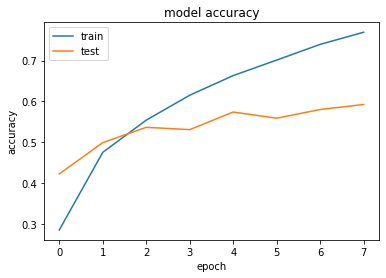

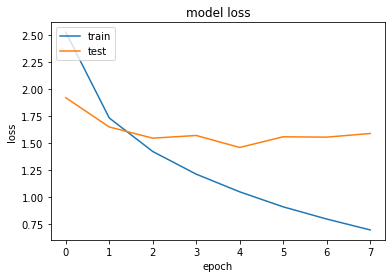

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Export weights

In [ ]:
weights = model.get_weights()
weight_dest = '/content/drive/MyDrive/Weights/'
np.save(weight_dest+'weight_cnn_hep.npy',weights)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# Classification for patterns before classification in levels
We limit the number of images to 1 per pattern for the classification, to mirror a doctor.

In [ ]:
# number of images
pattern_folder = '/content/drive/MyDrive/Images/Cells/CytoCells_pattern'
images_path = "/content/drive/MyDrive/Images/Patterns"
# we limit the number of images to 1
X, y, n_classes, pattern_dict, hist_pixel_count, hist_percentage_cyto = get_patterns_by_image(pattern_folder, 1, images_path)

In [ ]:
n_hep_classes = 47
pattern_count = 0
print("Predicting...")
for i, j in zip(X, y):
  # make predictions
  print(f"Pattern {pattern_dict[pattern_count]}")
  x_pred, _ = data_preparation(np.asarray(i), np.asarray(j), False, hist_pixel_count, hist_percentage_cyto, image_reshape_size, pattern_dict)
  prediction = np.zeros(n_hep_classes)
  for pred in np.argmax(model.predict(x_pred), axis=1):
    prediction[pred] += 1
  prediction /= x_pred.shape[0] # average
  print(f"Prediction: {y_pattern_dict[np.argmax(prediction)]}")
  idx = (-prediction).argsort()[:5]
  for n, top in enumerate(idx):
    print(f"Top {n+1} Prediction: {y_pattern_dict[int(top)]} - Probability: {prediction[int(top)]:.2f}")

  # plot predictions
  print(f"Number of cells: {x_pred.shape[0]}")
  mozaic , n = cells_plot(x_pred[:,:,:,0], image_reshape_size, 10)
  fig = plt.figure(figsize=(15,15))
  plt.imshow(mozaic)
  plt.title(f'Pattern {pattern_dict[pattern_count]} - Predicted: {y_pattern_dict[np.argmax(prediction)]}')
  plt.show()
  #affiche(mozaic,titre=f'Pattern {pattern_dict[pattern_count]} - Predicted: {y_pattern_dict[np.argmax(prediction)]}')
  pattern_count += 1

### Confusion matrix and classification by levels
First we see the confusion matrix for the classes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,Centromere,Controle neg,Cyto APL,Cyto Fibreux,Cyto Golgi,Cyto Ponctue GW,Cyto Ponctue Jo1,Cyto Ponctue Somes,Cyto atypique HMCOAR,Cyto atypique MDA5,Cyto filamenteux Vimentine,Cyto filamenteux actine,Cyto granuleux,CytoD EJ,CytoD PL12,CytoD PL7,CytoD SRP RiboP,DFS70,Dot p80,Dot sp100,Homogene,KI67,MCA perichromine,MSA2,MSA3,Mou CytoD PL7,Mouchete SSA,NUMA1,NUMA2,atypique OPT,atypique pleomorphe heterogene,centromere cytoD,centrosome,kinesine,kinesine midbody,mouchete M0,mouchete NXP2,mouchete RNApolIII,mouchete SAE1,mouchete TIF1,mouchete dot RNP,mouchete fin,nucleole RNA pol I,nucleole ThTo,nucleole fibrillarine,pleomorphe PCNA,vinculine


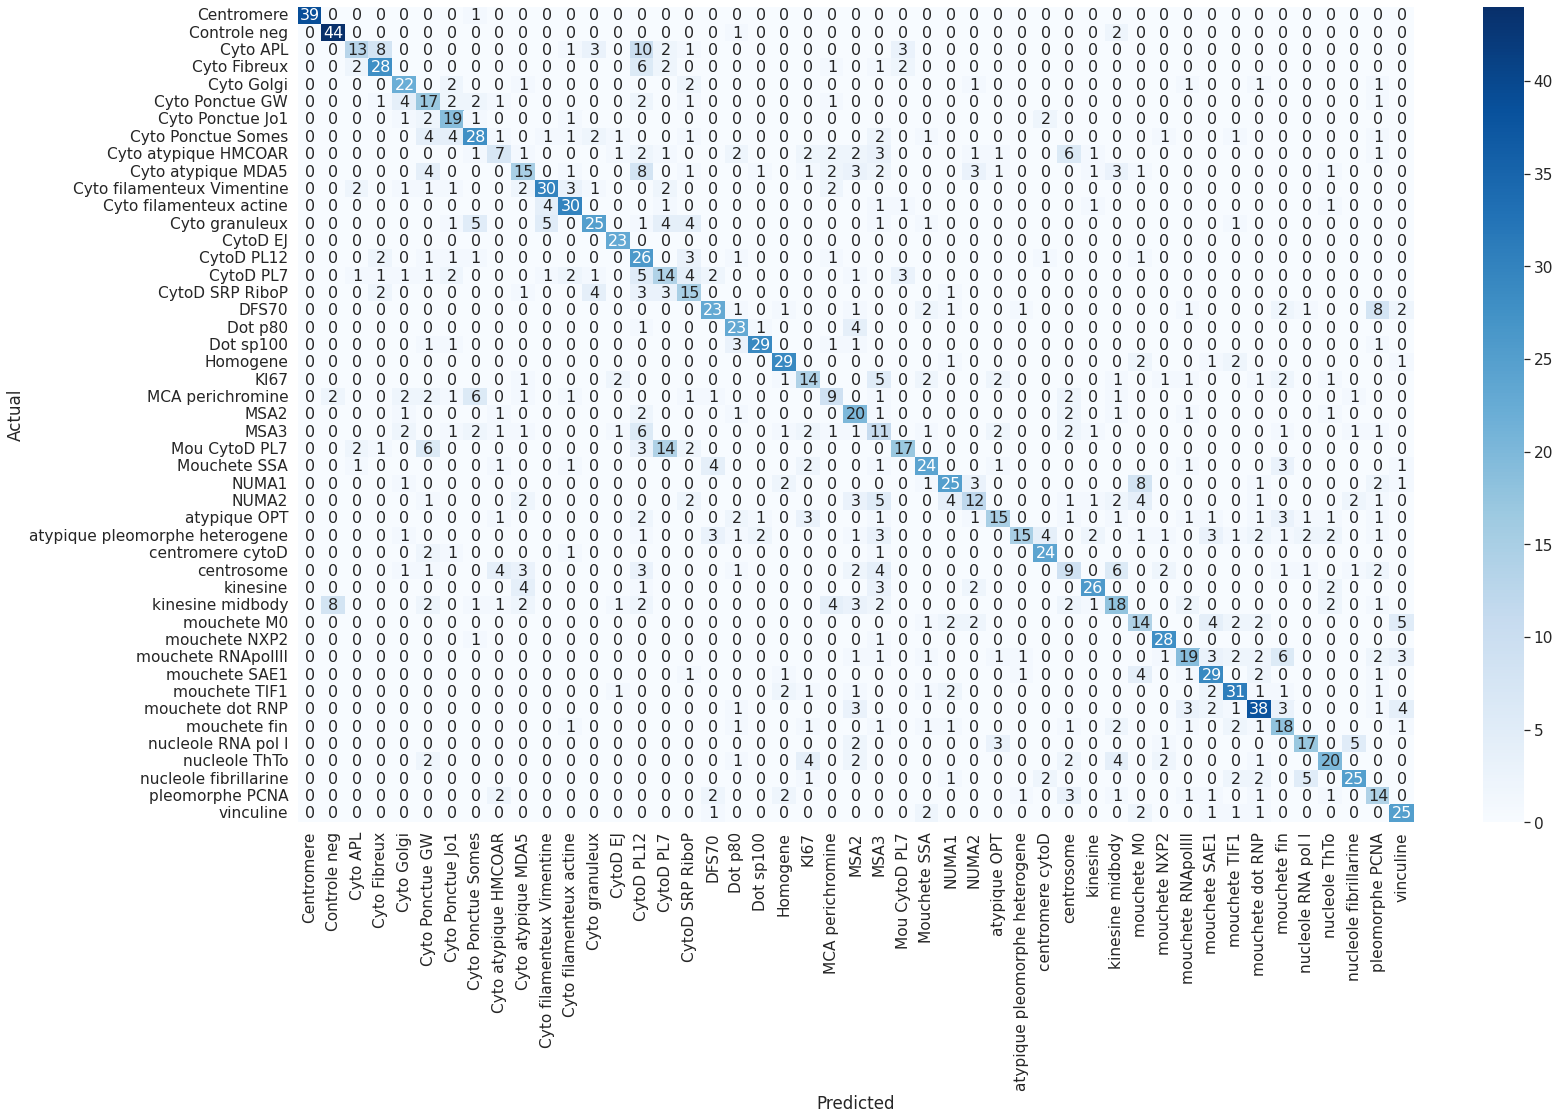

In [ ]:

true = np.argmax(y_test, axis=1)
test = np.argmax(model.predict(x_test), axis=1)
data = confusion_matrix(true, test)
df_cm = pd.DataFrame(data, columns=y_pattern_dict, index = y_pattern_dict)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (25,15))
plt.axes
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

df_index = pd.DataFrame(np.reshape(y_pattern_dict, (1,47)), columns=range(47))
df_index.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,Centromere,Controle neg,Cyto APL,Cyto Fibreux,Cyto Golgi,Cyto Ponctue GW,Cyto Ponctue Jo1,Cyto Ponctue Somes,Cyto atypique HMCOAR,Cyto atypique MDA5,Cyto filamenteux Vimentine,Cyto filamenteux actine,Cyto granuleux,CytoD EJ,CytoD PL12,CytoD PL7,CytoD SRP RiboP,DFS70,Dot p80,Dot sp100,Homogene,KI67,MCA perichromine,MSA2,MSA3,Mou CytoD PL7,Mouchete SSA,NUMA1,NUMA2,atypique OPT,atypique pleomorphe heterogene,centromere cytoD,centrosome,kinesine,kinesine midbody,mouchete M0,mouchete NXP2,mouchete RNApolIII,mouchete SAE1,mouchete TIF1,mouchete dot RNP,mouchete fin,nucleole RNA pol I,nucleole ThTo,nucleole fibrillarine,pleomorphe PCNA,vinculine


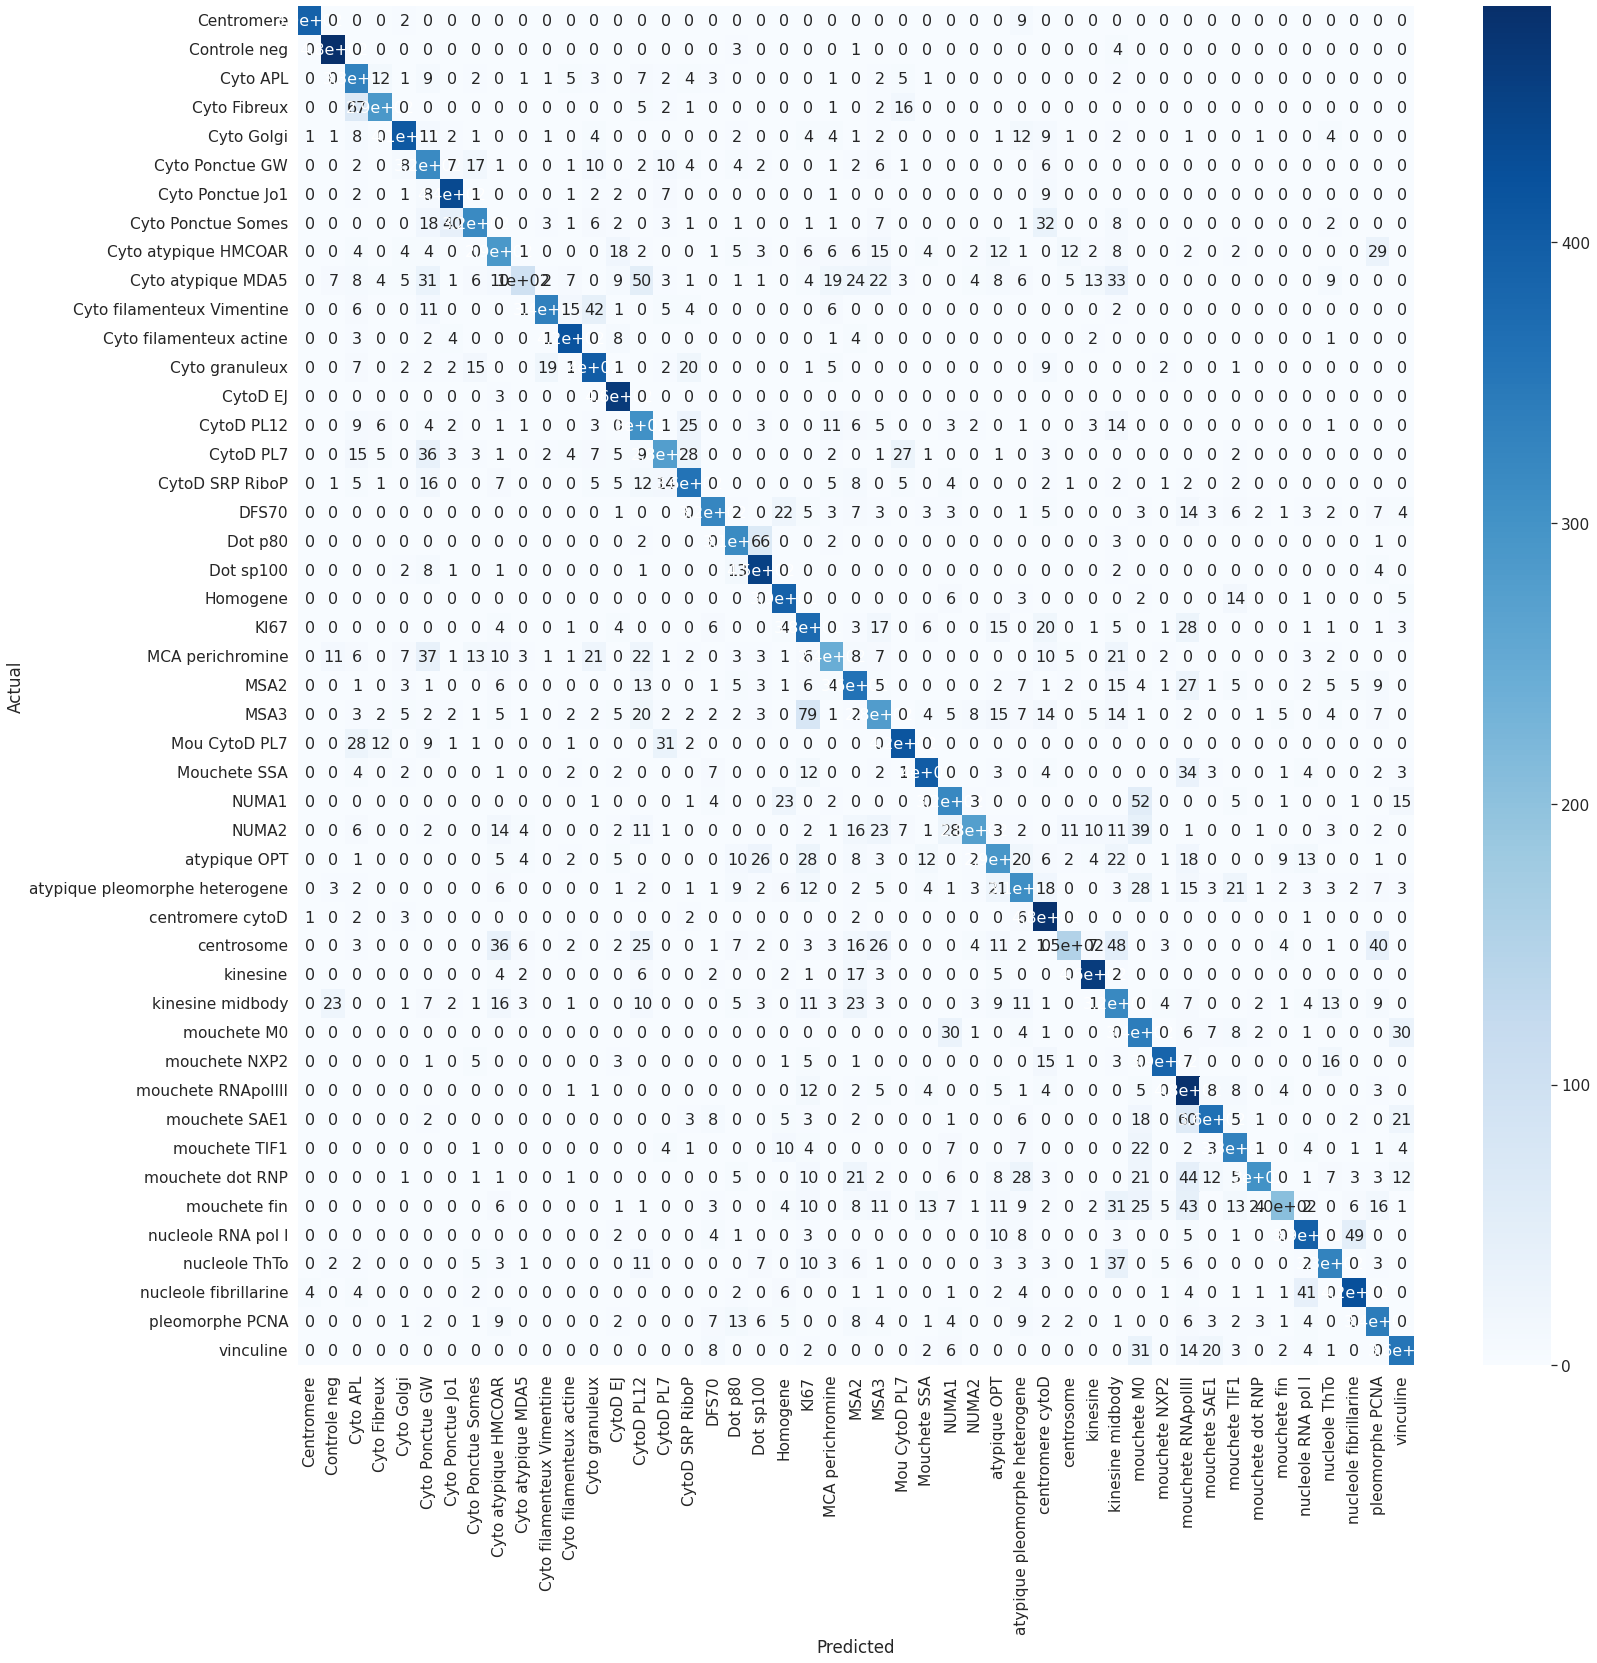

In [ ]:
true = np.argmax(y_train, axis=1)
test = np.argmax(model.predict(x_train), axis=1)
data = confusion_matrix(true, test)
df_cm = pd.DataFrame(data, columns=y_pattern_dict, index = y_pattern_dict)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (25,25))
plt.axes
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

df_index = pd.DataFrame(np.reshape(y_pattern_dict, (1,47)), columns=range(47))
df_index.head()

# Classification by levels to improve base classification


The idea of the dendogram division is to create clusters of classes that have high similarity, so that we can classify images into these cluster with more precision.

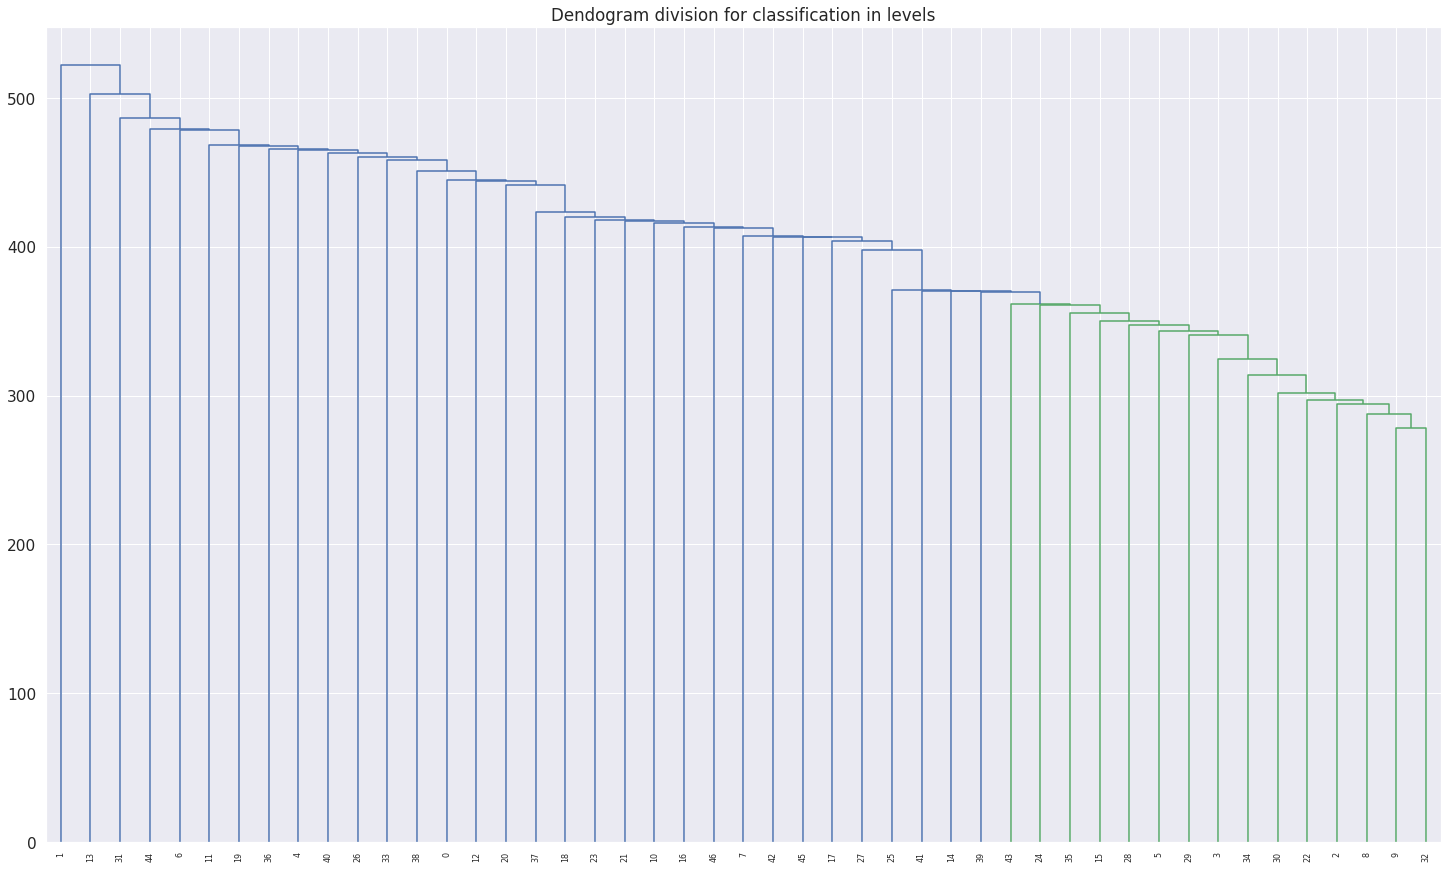

In [ ]:

# spc == hierarchy
pdist = spc.distance.pdist(data)
Z = spc.linkage(pdist, 'single')
plt.figure(figsize=(25,15))
plt.title("Dendogram division for classification in levels")
dn = spc.dendrogram(Z)

In [ ]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 1s 17ms/step - loss: 1.4905 - accuracy: 0.5679


[1.490515947341919, 0.5679150223731995]

We picked a linkage that makes our base segmentation easier, by making the dendogram descending.
From taking the base level division of the dendogram we have:


In [ ]:
base_segmentation = dn['ivl']
print(base_segmentation)
print(len(base_segmentation))


['1', '13', '31', '44', '6', '11', '19', '36', '4', '40', '26', '33', '38', '0', '12', '20', '37', '18', '23', '21', '10', '16', '46', '7', '42', '45', '17', '27', '25', '41', '14', '39', '43', '24', '35', '15', '28', '5', '29', '3', '34', '30', '22', '2', '8', '9', '32']
47


We then create three levels of classification for a multiclass by levels:
- The first in 3 classes
- The second in 4 classes
- The third in 4 classes
Since the classes on the right of the dendogram have more missclassification, they always end up on the groups with less classes.

Their dictionaries:

In [ ]:
first_level = [base_segmentation[16*first:min(47,16*(first+1))] for first in range(3)]
second_level = [[base_segmentation[16*first+4*second:min(47,16*first+4*(second+1))] for second in range(4)] for first in range(3)]
third_level = [[[base_segmentation[16*first+4*second+third:min(47,16*first+4*second+(third+1))] for third in range(4)] for second in range(4)] for first in range(3)]
print("first",first_level)
print("second",second_level)
print("third",third_level)

first [['1', '13', '31', '44', '6', '11', '19', '36', '4', '40', '26', '33', '38', '0', '12', '20'], ['37', '18', '23', '21', '10', '16', '46', '7', '42', '45', '17', '27', '25', '41', '14', '39'], ['43', '24', '35', '15', '28', '5', '29', '3', '34', '30', '22', '2', '8', '9', '32']]
second [[['1', '13', '31', '44'], ['6', '11', '19', '36'], ['4', '40', '26', '33'], ['38', '0', '12', '20']], [['37', '18', '23', '21'], ['10', '16', '46', '7'], ['42', '45', '17', '27'], ['25', '41', '14', '39']], [['43', '24', '35', '15'], ['28', '5', '29', '3'], ['34', '30', '22', '2'], ['8', '9', '32']]]
third [[[['1'], ['13'], ['31'], ['44']], [['6'], ['11'], ['19'], ['36']], [['4'], ['40'], ['26'], ['33']], [['38'], ['0'], ['12'], ['20']]], [[['37'], ['18'], ['23'], ['21']], [['10'], ['16'], ['46'], ['7']], [['42'], ['45'], ['17'], ['27']], [['25'], ['41'], ['14'], ['39']]], [[['43'], ['24'], ['35'], ['15']], [['28'], ['5'], ['29'], ['3']], [['34'], ['30'], ['22'], ['2']], [['8'], ['9'], ['32'], []]]